# Competitor Comparison

The purpose of this notebook is to compare the Robust Mixed Effects (RoME) algorithm to various competing algorithms.
This notebook contains three separate simulations that compare these methods.

In the first simulation, the standard Thompson sampling assumptions hold,
and the users are assumed to be homogeneous in the sense that their advantage functions (causal effects) are the same.

The second situation is similar, but users are heterogeneous in the sense that they have different advantage functions.

In the third simulation, the data-generating mechanism is much more complex.
In addition to being nonlinear, it also includes effects for users and time.
Consequently, only the RoME method performs well in this setting.

# Shared Setup

In [1]:
# Generic imports
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from scipy.stats import ttest_1samp
import matplotlib.pyplot as plt
import seaborn as sns
from river import linear_model
import copy
from multiprocessing import cpu_count
from joblib import Parallel, delayed
import pickle
import tensorflow as tf
import keras
from keras import layers, regularizers
import time

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 50)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1pppohr5 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2024-10-04 10:23:04.978862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Imports from this project
from models.models import OracleTS, StandardTS, ActionCenteredTS, RoME, IntelligentPooling, UserLaplacian
from models.river_wrapper import RiverBatchEstimator
from models.bagging_mod import BaggingRegressor
from models.utils import find_neighbors
from simulations.data_generator import DataGenerator

In [3]:
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
plt.rcParams['font.family'] = 'sans-serif'

In [4]:
# Simulation setup: try some different values
N_STAGES = 200
N_OBSERVATIONS = N_STAGES * (N_STAGES + 1) // 2
N = N_STAGES
T = N_STAGES
THETA = np.array([1., 0.5, -4.])
CONTEXT_DIM = 2
EXTRA_CONTEXT_DIM = 2
LINEAR_BASELINE_COEF = np.array([2., -2., 3.])
THETA_TIME_INIT = np.array([-2., -4., 6.])
P = THETA.size
n_jobs = 25
REPS = 50
N_NEIGHBORS = 5

In [5]:
def get_max_norm(x):
    squared_norms = (x**2).sum(axis=1)
    norms = np.sqrt(squared_norms)
    max_norm = np.max(norms)
    return max_norm

def get_max_norm_for_pairs(x, pairs):
    x_diffs = x[pairs[0]] - x[pairs[1]]
    max_norm = get_max_norm(x_diffs)
    return max_norm

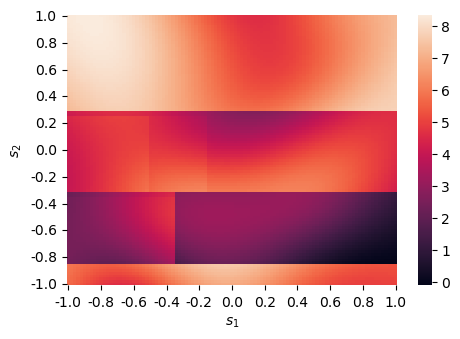

In [6]:
homogeneous_data_generator = DataGenerator(stage_max=N_STAGES, assumptions="homogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
homogeneous_data_generator = homogeneous_data_generator.sample_theta(theta_base=THETA)

heterogeneous_data_generator = DataGenerator(stage_max=N_STAGES, assumptions="heterogeneous", linear_baseline_coef=LINEAR_BASELINE_COEF, random_seed=1)
heterogeneous_data_generator = heterogeneous_data_generator.sample_theta(theta_base=THETA)

nonlinear_data_generator = DataGenerator(stage_max=N_STAGES, assumptions="nonlinear", random_seed=3, nonlinear_scale=1.)  # Seed chosen for its interesting nonlinear relationships
nonlinear_data_generator = nonlinear_data_generator.sample_theta(theta_base=THETA, theta_time_init=THETA_TIME_INIT)

# Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)
heatmap_min = np.min(baseline_vals)
heatmap_max = np.max(baseline_vals)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(baseline_vals_df, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/baseline_reward.png")
fig.savefig("figures/baseline_reward.pdf")
plt.show()

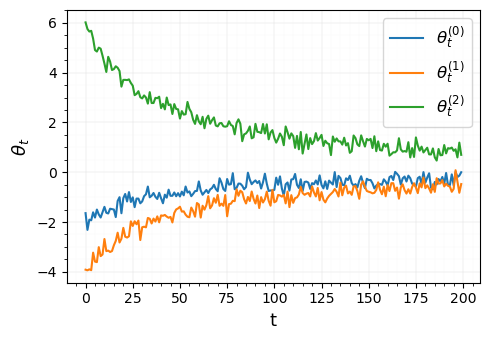

In [7]:
# Time-specifc thetas
fig, ax = plt.subplots(figsize=(5, 3.5))
for i in range(THETA.size):
    label = "$\\theta^{(idx)}_{t}$".replace("idx", str(i))
    ax.plot(nonlinear_data_generator.theta_time[:, i], alpha=1, label=label)
ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
ax.minorticks_on()
ax.set_xlabel("t", fontsize=13)
ax.set_ylabel("$\\theta_{t}$", fontsize=13)
# plt.title("Values of $\\theta_{time}$ Plotted Over Time")
ax.legend(fontsize=12)
fig.tight_layout()
fig.savefig("figures/theta_time.png")
fig.savefig("figures/theta_time.pdf")
plt.show()

2024-10-04 10:23:10.973346: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 1.5382 - val_loss: 1.1036
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0710 - val_loss: 1.0732
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0554 - val_loss: 1.0781
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0413 - val_loss: 1.0397
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0428 - val_loss: 1.0438
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0353 - val_loss: 1.0506
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0252 - val_loss: 1.0371
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0339 - val_loss: 1.0370
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0269 - val_loss: 1.0512
Epoch 10/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0264 - val_loss: 1.0417

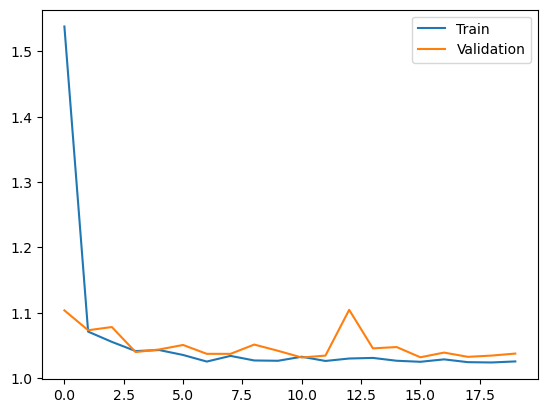

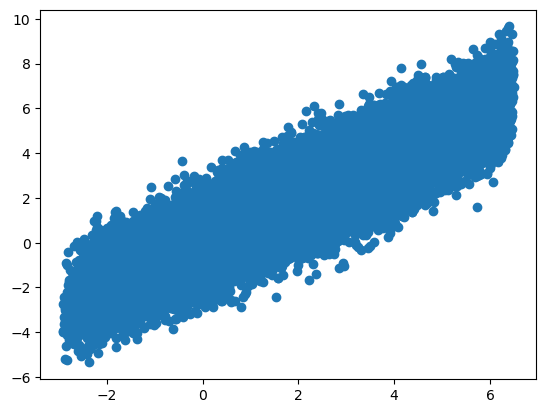

INFO:tensorflow:Assets written to: tri-homogeneous-nn/assets


INFO:tensorflow:Assets written to: tri-homogeneous-nn/assets


Epoch 1/20
200/200 [==============================] - 1s 2ms/step - loss: 1.5545 - val_loss: 1.0975
Epoch 2/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0795 - val_loss: 1.0828
Epoch 3/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0641 - val_loss: 1.1036
Epoch 4/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0584 - val_loss: 1.0541
Epoch 5/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0514 - val_loss: 1.1182
Epoch 6/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0478 - val_loss: 1.0503
Epoch 7/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0462 - val_loss: 1.0512
Epoch 8/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0444 - val_loss: 1.0533
Epoch 9/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0421 - val_loss: 1.0462
Epoch 10/20
200/200 [==============================] - 0s 1ms/step - loss: 1.0397 - val_loss: 1.0576

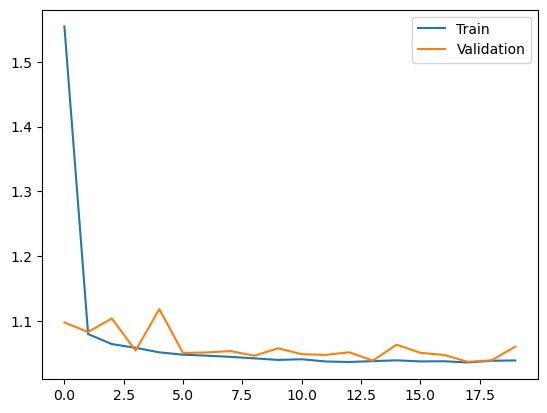

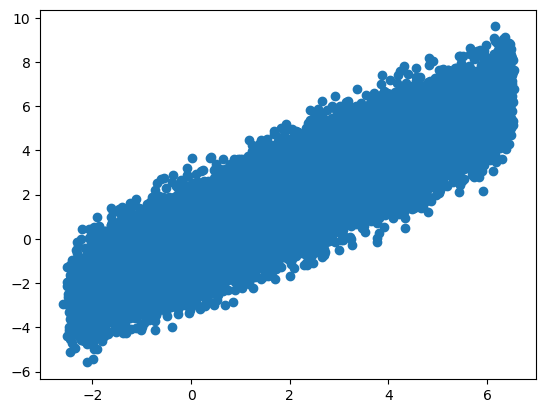

INFO:tensorflow:Assets written to: tri-heterogeneous-nn/assets


INFO:tensorflow:Assets written to: tri-heterogeneous-nn/assets


Epoch 1/50
200/200 [==============================] - 1s 2ms/step - loss: 5.0183 - val_loss: 3.1759
Epoch 2/50
200/200 [==============================] - 0s 1ms/step - loss: 2.6494 - val_loss: 2.0656
Epoch 3/50
200/200 [==============================] - 0s 1ms/step - loss: 1.7844 - val_loss: 1.5581
Epoch 4/50
200/200 [==============================] - 0s 1ms/step - loss: 1.5866 - val_loss: 1.5932
Epoch 5/50
200/200 [==============================] - 0s 1ms/step - loss: 1.5100 - val_loss: 1.4959
Epoch 6/50
200/200 [==============================] - 0s 1ms/step - loss: 1.4598 - val_loss: 1.4882
Epoch 7/50
200/200 [==============================] - 0s 1ms/step - loss: 1.4433 - val_loss: 1.5832
Epoch 8/50
200/200 [==============================] - 0s 1ms/step - loss: 1.3944 - val_loss: 1.4717
Epoch 9/50
200/200 [==============================] - 0s 1ms/step - loss: 1.3884 - val_loss: 1.3887
Epoch 10/50
200/200 [==============================] - 0s 1ms/step - loss: 1.3525 - val_loss: 1.3607

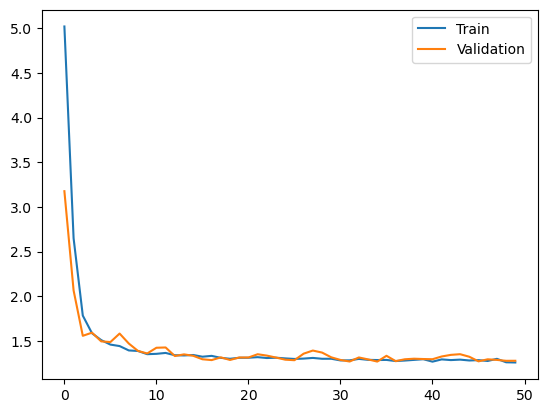

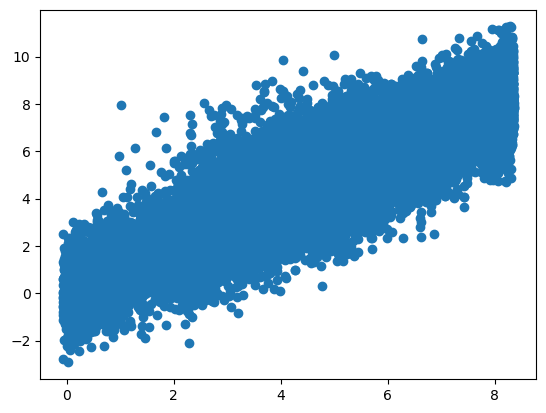

INFO:tensorflow:Assets written to: tri-nonlinear-nn/assets


INFO:tensorflow:Assets written to: tri-nonlinear-nn/assets


CPU times: user 41.1 s, sys: 7.65 s, total: 48.8 s
Wall time: 29 s


In [8]:
%%time
# Neural network stuff
nn_input_dim = CONTEXT_DIM + EXTRA_CONTEXT_DIM

data_generators = [homogeneous_data_generator, heterogeneous_data_generator, nonlinear_data_generator]
model_files = ["tri-homogeneous-nn", "tri-heterogeneous-nn", "tri-nonlinear-nn"]
for i, (data_generator, model_file) in enumerate(zip(data_generators, model_files)):
    # Create data
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_train, y_train = data_generator.generate_baselines_for_nn()
    
    data_generator = data_generator.reset()
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)
    X_validation, y_validation = data_generator.generate_baselines_for_nn()
    
    # Train model
    penalty = 0.001
    nn_output_dim = 10
    model = keras.Sequential(
        [
            keras.Input(shape=(nn_input_dim,), name="input"),
            layers.Dense(10, activation="relu", name="layer1", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="relu", name="layer2", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(20, activation="tanh", name="layer3", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(nn_output_dim, activation="tanh", name="layer4", kernel_regularizer=regularizers.l2(penalty)),
            layers.Dense(1, name="output", kernel_regularizer=regularizers.l2(penalty)),
        ]
    )
    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss="mse", optimizer=opt)
    history = model.fit(
        X_train,
        y_train,
        batch_size=200,
        validation_data=(X_validation, y_validation),
        epochs=50 if i == 2 else 20,
        # epochs=1,
        verbose=1
    )
    
    plt.plot(history.history['loss'], label="Train")
    plt.plot(history.history['val_loss'], label="Validation")
    plt.legend()
    plt.show()

    preds_validation = model(X_validation)
    plt.scatter(preds_validation, y_validation)
    plt.show()
    
    # Featurizer model
    featurizer_nn_model = keras.Model(
        inputs=model.input,
        outputs=model.get_layer("layer4").output)
    featurizer_nn_model.compile()
    featurizer_nn_model.save(model_file)

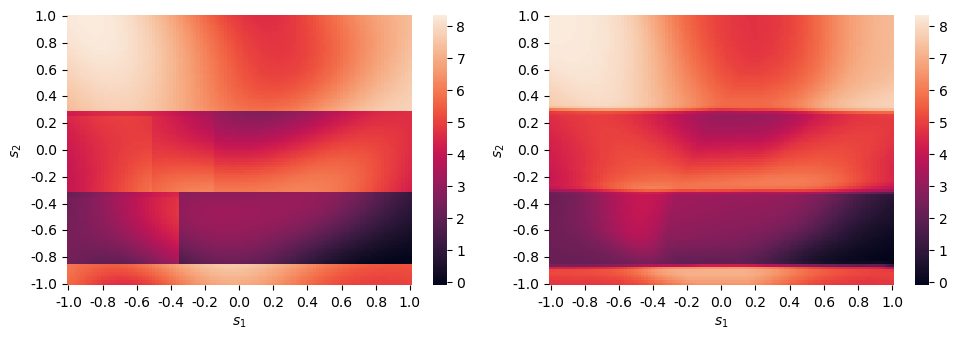

In [9]:
# Baseline Reward
num_vals = 101
s1_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s2_vals = np.round(np.linspace(-1., 1., num=num_vals), 2)
s1_vals_repped, s2_vals_repped = np.meshgrid(s1_vals, s2_vals)
context_values = np.vstack([s1_vals_repped.flatten(), s2_vals_repped.flatten()]).T
baseline_vals = nonlinear_data_generator._nonlinear_baseline_function(context_values, scale=nonlinear_data_generator.nonlinear_scale)

baseline_vals_df = pd.DataFrame(
    data=baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
sns.heatmap(baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[0])
ax[0].set_xlabel("$s_{1}$")
ax[0].set_ylabel("$s_{2}$")

nn_context_values = np.hstack([context_values, np.zeros_like(context_values)])
nn_baseline_vals = model(nn_context_values).numpy()
nn_baseline_vals_df = pd.DataFrame(
    data=nn_baseline_vals.reshape((num_vals, num_vals)),
    index=s1_vals,
    columns=s2_vals).sort_index(ascending=False)

sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax[1])
ax[1].set_xlabel("$s_{1}$")
ax[1].set_ylabel("$s_{2}$")

fig.tight_layout()
fig.savefig("figures/nn_baseline_reward_comparison.png")
fig.savefig("figures/nn_baseline_reward_comparison.pdf")
plt.show()

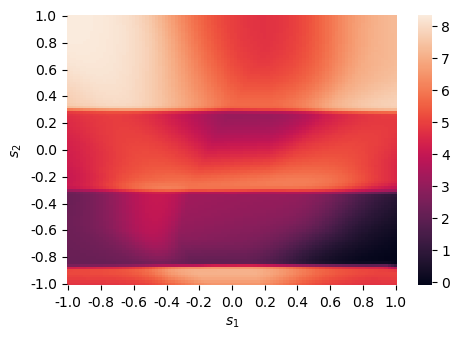

In [10]:
fig, ax = plt.subplots(figsize=(5, 3.5))
ax = sns.heatmap(nn_baseline_vals_df, vmin=heatmap_min, vmax=heatmap_max, xticklabels=10, yticklabels=10, ax=ax)
plt.xlabel("$s_{1}$")
plt.ylabel("$s_{2}$")
# plt.title("Baseline Reward as a Function of State")
fig.tight_layout()
fig.savefig("figures/nn_baseline_reward.png")
fig.savefig("figures/nn_baseline_reward.pdf")
plt.show()

In [11]:
# This determines the plotting order
non_oracle_method_names = [
    "IntelPooling",
    "RoME-BLM",
    "RoME",
    "RoME-SU",
    "AC",
    "Standard",
    "Neural-Linear",
    "NNR-Linear"
]

def create_reward_dict(data_generator, nn_model_name, seed):
    np.random.seed(seed)
    user_pairs, L_user = find_neighbors(data_generator.theta_user, N_NEIGHBORS)
    time_pairs, L_time = find_neighbors(data_generator.theta_time, N_NEIGHBORS)
    
    # Doubling these values to make them more reasonable
    d_user = get_max_norm(data_generator.theta_user) * 2
    d_time = get_max_norm(data_generator.theta_time) * 2
    b_user = get_max_norm_for_pairs(data_generator.theta_user, user_pairs) * 2
    b_time = get_max_norm_for_pairs(data_generator.theta_time, time_pairs) * 2
    bagged_lm = RiverBatchEstimator(
        BaggingRegressor(
            linear_model.LinearRegression(l2=1e-8, intercept_lr=0.1),
            n_models=10,
            subsample=0.8
        )
    )

    # Set covariances
    cov_epsilon = 1e-18
    user_cov = np.cov(data_generator.theta_user.T)
    if user_cov.sum() < cov_epsilon:
        user_cov += cov_epsilon * np.eye(user_cov.shape[0])
    time_cov = np.cov(data_generator.theta_time.T)
    if time_cov.sum() < cov_epsilon:
        time_cov += cov_epsilon * np.eye(time_cov.shape[0])

    nn = tf.keras.models.load_model(nn_model_name)
    nn_numpy = lambda x: nn(x).numpy()
    
    non_oracle_methods_dict = {
        "IntelPooling": IntelligentPooling(N, T, P, DataGenerator._featurize, user_cov=user_cov, time_cov=time_cov),
        "RoME": RoME(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS),
        "RoME-BLM": RoME(N, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, ml_interactions=True, ml_model=bagged_lm, n_neighbors=N_NEIGHBORS),
        "RoME-SU": RoME(1, T, P, DataGenerator._featurize, L_user, L_time, user_cov=user_cov, time_cov=time_cov, b_user=b_user, b_time=b_time, d_user=d_user, d_time=d_time, n_neighbors=N_NEIGHBORS, pool_users=False),
        "AC": ActionCenteredTS(N, T, P, DataGenerator._featurize),
        "Standard": StandardTS(N, T, P, DataGenerator._featurize),
        "Neural-Linear": StandardTS(N, T, P, DataGenerator._featurize, nn=nn_numpy, nn_dim=nn_output_dim),
        "NNR-Linear": UserLaplacian(N, T, P, DataGenerator._featurize, L_user, user_cov=user_cov),
    }
    methods_dict = copy.copy(non_oracle_methods_dict)
    methods_dict["Oracle"] = OracleTS(N, T, THETA, data_generator.theta_user, data_generator.theta_time, DataGenerator._featurize)
    
    # Dictionary for storing rewards
    rewards_dict = {k:np.zeros((N, T)) for k in methods_dict}
    timings_dict = {}

    # Generate context vectors that we'll use for all models
    data_generator = data_generator.generate_all_contexts(context_dim=CONTEXT_DIM, extra_context_dim=EXTRA_CONTEXT_DIM)

    # Iterate through methods
    for method_name, method in methods_dict.items():
        rewards = []
        data_generator = data_generator.reset()
        method.reset()
        method_start_time = time.time()

        while not data_generator.finished:
            # Randomly samples action from current policy
            context, context_extra, user_idx, time_idx = data_generator.get_current_context()
            action = method.sample_action(context, user_idx, time_idx)

            # Plays action and returns reward
            reward = data_generator.play_action(action)
            rewards_dict[method_name][user_idx, time_idx] = reward

            # Update method inferences
            method.update(context, context_extra, user_idx, time_idx, action, reward)
        method_end_time = time.time()
        method_elapsed_time = method_end_time - method_start_time
        timings_dict[method_name] = method_elapsed_time

    return rewards_dict, timings_dict

In [12]:
def run_simulation(data_generator, nn_model_name, REPS=REPS, n_jobs=cpu_count()):    
    # Perform whole simulation REPS times
    pool_args = zip(
        [copy.deepcopy(data_generator) for _ in range(REPS)],
        [nn_model_name]*REPS,
        range(REPS))
    print("Starting parallel")
    list_of_tuples_of_dicts = Parallel(n_jobs=n_jobs)(delayed(create_reward_dict)(*arg) for arg in pool_args)    
    print("Parallel closed")
    rewards_list_of_dicts = [t[0] for t in list_of_tuples_of_dicts]
    timings_list_of_dicts = [t[1] for t in list_of_tuples_of_dicts]
    rewards_dict = {}
    timings_dict = {}
    method_names = list(rewards_list_of_dicts[0].keys())
    non_oracle_method_names = list(set(method_names) - set(["Oracle"]))
    for method_name in method_names:
        rewards_dict[method_name] = np.asarray([
            rewards_list_of_dicts[i][method_name]
            for i in range(REPS)])
        timings_dict[method_name] = np.asarray([
            timings_list_of_dicts[i][method_name]
            for i in range(REPS)])
                
    return rewards_dict, timings_dict

In [13]:
def get_avg_stage_reward(a):
    means = [a[:, ::-1].diagonal(i, axis1=1, axis2=2).mean(axis=1) for i in range(-a.shape[1]+1,a.shape[2])]
    return np.asarray(means)[:a.shape[1]]


def plot_rewards_dict(rewards_dict, assumptions):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax0 = ax[0]
    ax1 = ax[1]
    
    # Calculate incremental regret
    oracle_incremental_regret = get_avg_stage_reward(rewards_dict["Oracle"])
    incremental_regret_dict = {
        method_name: (oracle_incremental_regret - get_avg_stage_reward(rewards_dict[method_name])).mean(axis=1)  # Mean over reps
        for method_name in non_oracle_method_names}

    # Calculate cumulative regret
    cumulative_regret_dict = {method_name: np.cumsum(incremental_regret_dict[method_name]) for method_name in non_oracle_method_names}

    # Plot incremental regret
    for method_name in non_oracle_method_names:
        ax0.plot(incremental_regret_dict[method_name], label=method_name, )
    ax0.set_title("(a) Incremental Regret Over Time", pad=10)
    ax0.set_ylabel("Incremental Regret")
    ax0.set_xlabel("Stage")
    ax0.legend()

    # Plot cumulative regret
    for method_name in non_oracle_method_names:
        ax1.plot(cumulative_regret_dict[method_name], label=method_name)
    ax1.set_title("(b) Cumulative Regret Over Time", pad=10)
    ax1.set_ylabel("Cumulative Regret")
    ax1.set_xlabel("Stage")
    plt.legend()

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    fig.savefig(f"figures/{assumptions}-regret.png")
    fig.savefig(f"figures/{assumptions}-regret.pdf")
    fig.suptitle(f"Regret for {assumptions.capitalize()} Data-Generating Process")
    plt.show()

# Simulation 1: Homogeneous Users, Linear Baseline, No Time Effects

In [14]:
%%time
homogeneous_rewards_dict, homogeneous_timings_dict = run_simulation(homogeneous_data_generator, model_files[0], n_jobs=n_jobs)

Starting parallel


2024-10-04 10:23:45.142545: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:23:45.143880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:23:45.153566: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 

Parallel closed
CPU times: user 648 ms, sys: 869 ms, total: 1.52 s
Wall time: 34min 20s


In [15]:
def print_timings(timings_dict_):
    print("Average elapsed time by method")
    for k in timings_dict_:
        mean_timing = timings_dict_[k].mean()
        print(f"{k}: {mean_timing}")
    timings_df = pd.DataFrame(timings_dict_)
    print(timings_df)
    return timings_df
print_timings(homogeneous_timings_dict)

Average elapsed time by method
IntelPooling: 46.27682633399964
RoME: 345.2079056739807
RoME-BLM: 45.64631068229675
RoME-SU: 355.62951055526736
AC: 0.11539803981781006
Standard: 0.15963747024536132
Neural-Linear: 0.7103007221221924
NNR-Linear: 29.752740740776062
Oracle: 0.019454050064086913
    IntelPooling        RoME   RoME-BLM     RoME-SU        AC  Standard  \
0      48.229624  327.457841  47.504876  340.829393  0.113885  0.158784   
1      48.028614  327.757638  47.439753  339.428797  0.113938  0.158813   
2      47.761692  325.560891  47.185848  344.113340  0.114676  0.157801   
3      47.993612  330.244854  47.228861  359.738591  0.118646  0.162862   
4      47.676034  323.004864  47.736889  349.876035  0.114820  0.159829   
5      47.426709  331.172095  47.315262  350.934046  0.113360  0.159281   
6      48.145792  320.011020  47.499636  336.850810  0.114792  0.159194   
7      48.994974  326.459207  48.106463  348.552370  0.119154  0.161883   
8      48.143186  321.180061  47.4

,IntelPooling,RoME,RoME-BLM,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear,Oracle
0,48.229624,327.457841,47.504876,340.829393,0.113885,0.158784,0.737768,29.803846,0.019852
1,48.028614,327.757638,47.439753,339.428797,0.113938,0.158813,0.733867,28.993097,0.019878
2,47.761692,325.560891,47.185848,344.113340,0.114676,0.157801,0.732915,29.287914,0.018434
3,47.993612,330.244854,47.228861,359.738591,0.118646,0.162862,0.778236,30.816704,0.023667
4,47.676034,323.004864,47.736889,349.876035,0.114820,0.159829,0.747666,29.631185,0.019553
5,47.426709,331.172095,47.315262,350.934046,0.113360,0.159281,0.735557,29.873555,0.019843
6,48.145792,320.011020,47.499636,336.850810,0.114792,0.159194,0.744060,29.083165,0.018507
7,48.994974,326.459207,48.106463,348.552370,0.119154,0.161883,0.733892,29.949360,0.020722
8,48.143186,321.180061,47.459461,335.584161,0.117536,0.158459,0.748357,29.715532,0.018573
9,47.315095,320.333237,47.742013,335.585887,0.114294,0.158311,0.732094,29.211434,0.018346


In [16]:
homogeneous_rewards_filename = "checkpoints/homogeneous_rewards.pkl"
with open(homogeneous_rewards_filename, 'wb') as file:
    pickle.dump(homogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
with open(homogeneous_rewards_filename, "rb") as file:
    homogeneous_rewards_dict = pickle.load(file)

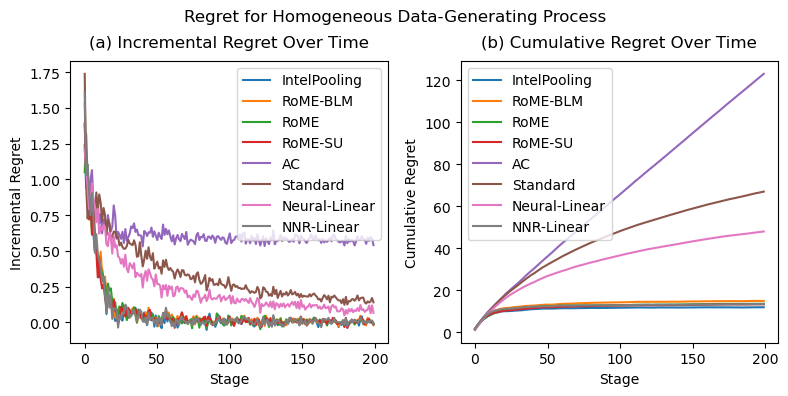

In [18]:
plot_rewards_dict(homogeneous_rewards_dict, "homogeneous")

# Simulation 2: Heterogeneous Users, Linear Baseline, No Time Effects

In [19]:
%%time
heterogeneous_rewards_dict, heterogeneous_timings_dict = run_simulation(heterogeneous_data_generator, model_files[1], n_jobs=n_jobs)

Starting parallel


2024-10-04 10:58:31.986714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:58:31.987178: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 10:58:31.987284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 

Parallel closed
CPU times: user 701 ms, sys: 982 ms, total: 1.68 s
Wall time: 38min 59s


In [20]:
print_timings(heterogeneous_timings_dict)

Average elapsed time by method
IntelPooling: 43.920955905914305
RoME: 373.412627825737
RoME-BLM: 49.4023588514328
RoME-SU: 375.5106534099579
AC: 0.11812544345855713
Standard: 0.16839104175567626
Neural-Linear: 0.7402292442321777
NNR-Linear: 31.856780672073363
Oracle: 0.019712376594543456
    IntelPooling        RoME   RoME-BLM     RoME-SU        AC  Standard  \
0      43.472672  330.879368  49.411906  346.652996  0.114297  0.158870   
1      45.253031  321.356645  51.321809  340.917227  0.115160  0.158306   
2      41.771939  352.352019  53.218549  414.650866  0.225857  0.321340   
3      41.874585  345.946415  55.084408  428.030753  0.117701  0.160862   
4      43.038725  326.195934  50.770584  336.851955  0.115368  0.159063   
5      43.159395  326.318076  48.609377  341.946544  0.115183  0.158378   
6      44.827176  332.187508  51.234336  355.044574  0.115039  0.159677   
7      43.445288  340.927247  54.604886  413.707416  0.130028  0.294278   
8      44.014454  345.951720  53.654

,IntelPooling,RoME,RoME-BLM,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear,Oracle
0,43.472672,330.879368,49.411906,346.652996,0.114297,0.158870,0.719545,30.926126,0.019114
1,45.253031,321.356645,51.321809,340.917227,0.115160,0.158306,0.726796,31.186018,0.019645
2,41.771939,352.352019,53.218549,414.650866,0.225857,0.321340,1.343400,33.265720,0.019779
3,41.874585,345.946415,55.084408,428.030753,0.117701,0.160862,0.805552,34.814621,0.020388
4,43.038725,326.195934,50.770584,336.851955,0.115368,0.159063,0.731616,31.161162,0.018436
5,43.159395,326.318076,48.609377,341.946544,0.115183,0.158378,0.726480,30.989554,0.018393
6,44.827176,332.187508,51.234336,355.044574,0.115039,0.159677,0.742532,31.760203,0.018994
7,43.445288,340.927247,54.604886,413.707416,0.130028,0.294278,0.796756,35.211094,0.019633
8,44.014454,345.951720,53.654140,425.150207,0.115000,0.158738,0.728237,33.426905,0.019790
9,43.922677,321.152251,49.245187,341.544290,0.116866,0.161403,0.765447,31.970653,0.019007


In [21]:
heterogeneous_rewards_filename = "checkpoints/heterogeneous_rewards.pkl"
with open(heterogeneous_rewards_filename, 'wb') as file:
    pickle.dump(heterogeneous_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
with open(heterogeneous_rewards_filename, "rb") as file:
    heterogeneous_rewards_dict = pickle.load(file)

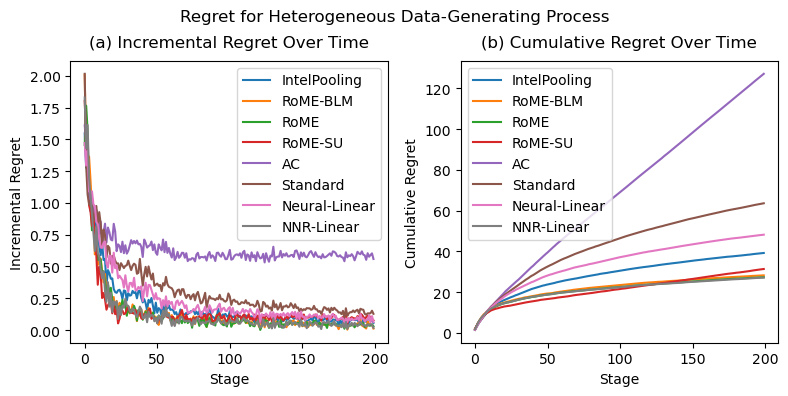

In [23]:
plot_rewards_dict(heterogeneous_rewards_dict, "heterogeneous")

# Simulation 3: Nonlinear Baseline and User-/Time-specific Effects

In [24]:
%%time
nonlinear_rewards_dict, nonlinear_timings_dict = run_simulation(nonlinear_data_generator, model_files[2], n_jobs=n_jobs)

Starting parallel


2024-10-04 11:37:11.287054: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 11:37:11.768564: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 11:37:11.784680: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 

Parallel closed
CPU times: user 710 ms, sys: 1.17 s, total: 1.88 s
Wall time: 37min 3s


In [25]:
print_timings(nonlinear_timings_dict)

Average elapsed time by method
IntelPooling: 46.84065249919891
RoME: 362.1879555225372
RoME-BLM: 52.217204461097715
RoME-SU: 366.23823848247525
AC: 0.25857494354248045
Standard: 0.3039089632034302
Neural-Linear: 0.8912145185470581
NNR-Linear: 31.649388585090637
Oracle: 0.15721923351287842
    IntelPooling        RoME   RoME-BLM     RoME-SU        AC  Standard  \
0      47.466094  333.313844  51.902433  346.413260  0.255003  0.303613   
1      50.491578  334.711744  53.839994  342.631233  0.257763  0.300489   
2      48.567901  334.643003  55.674938  346.716525  0.258199  0.303165   
3      48.243762  335.098594  51.416988  357.446246  0.254589  0.297930   
4      48.206447  331.367401  51.407821  342.251371  0.254479  0.300654   
5      48.374482  329.181672  54.198072  347.595369  0.264637  0.305161   
6      49.129946  337.509168  54.169077  343.104236  0.256140  0.296333   
7      48.438323  332.046929  51.385187  350.890798  0.329251  0.335672   
8      48.584498  344.664866  53.89

,IntelPooling,RoME,RoME-BLM,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear,Oracle
0,47.466094,333.313844,51.902433,346.413260,0.255003,0.303613,0.912302,31.429935,0.155065
1,50.491578,334.711744,53.839994,342.631233,0.257763,0.300489,0.887224,31.830539,0.157683
2,48.567901,334.643003,55.674938,346.716525,0.258199,0.303165,0.886779,32.537169,0.158854
3,48.243762,335.098594,51.416988,357.446246,0.254589,0.297930,0.935889,31.280825,0.153275
4,48.206447,331.367401,51.407821,342.251371,0.254479,0.300654,0.927197,31.104446,0.152939
5,48.374482,329.181672,54.198072,347.595369,0.264637,0.305161,0.915475,32.211448,0.161419
6,49.129946,337.509168,54.169077,343.104236,0.256140,0.296333,0.887761,31.254265,0.152411
7,48.438323,332.046929,51.385187,350.890798,0.329251,0.335672,1.101224,34.846940,0.186562
8,48.584498,344.664866,53.890644,348.514588,0.255430,0.299812,0.904408,31.405032,0.155432
9,52.000095,335.152505,54.536980,352.643317,0.257090,0.300772,0.894924,31.722988,0.155011


In [26]:
nonlinear_rewards_filename = "checkpoints/nonlinear_rewards.pkl"
with open(nonlinear_rewards_filename, 'wb') as file:
    pickle.dump(nonlinear_rewards_dict, file, protocol=pickle.HIGHEST_PROTOCOL)

In [27]:
with open(nonlinear_rewards_filename, "rb") as file:
    nonlinear_rewards_dict = pickle.load(file)

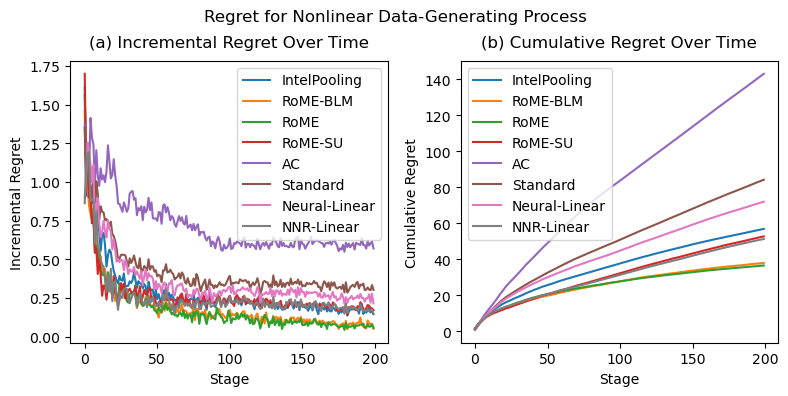

In [28]:
plot_rewards_dict(nonlinear_rewards_dict, "nonlinear")

# Cumulative Regret for All Three Settings

## Calculations

In [29]:
# Calculate incremental regret
incremental_homogeneous_regret_dict = {
    method_name: get_avg_stage_reward(homogeneous_rewards_dict["Oracle"]) - get_avg_stage_reward(homogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_heterogeneous_regret_dict = {
    method_name: get_avg_stage_reward(heterogeneous_rewards_dict["Oracle"]) - get_avg_stage_reward(heterogeneous_rewards_dict[method_name])
    for method_name in non_oracle_method_names}
incremental_nonlinear_regret_dict = {
    method_name: get_avg_stage_reward(nonlinear_rewards_dict["Oracle"]) - get_avg_stage_reward(nonlinear_rewards_dict[method_name])
    for method_name in non_oracle_method_names}

# Calculate cumulative regret
cumulative_homogeneous_regret_dict = {method_name: np.cumsum(incremental_homogeneous_regret_dict[method_name], axis=0) for method_name in non_oracle_method_names}
cumulative_heterogeneous_regret_dict = {method_name: np.cumsum(incremental_heterogeneous_regret_dict[method_name], axis=0) for method_name in non_oracle_method_names}
cumulative_nonlinear_regret_dict = {method_name: np.cumsum(incremental_nonlinear_regret_dict[method_name], axis=0) for method_name in non_oracle_method_names}

# Final regret
final_homogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_homogeneous_regret_dict[method_name][-1]
    for method_name in non_oracle_method_names})
final_homogeneous_regret_df.to_csv("./checkpoints/final_homogeneous_regret.csv", index=False)

final_heterogeneous_regret_df = pd.DataFrame({
    method_name: cumulative_heterogeneous_regret_dict[method_name][-1]
    for method_name in non_oracle_method_names})
final_heterogeneous_regret_df.to_csv("./checkpoints/final_heterogeneous_regret.csv", index=False)

final_nonlinear_regret_df = pd.DataFrame({
    method_name: cumulative_nonlinear_regret_dict[method_name][-1]
    for method_name in non_oracle_method_names})
final_nonlinear_regret_df.to_csv("./checkpoints/final_nonlinear_regret.csv", index=False)

## Plots

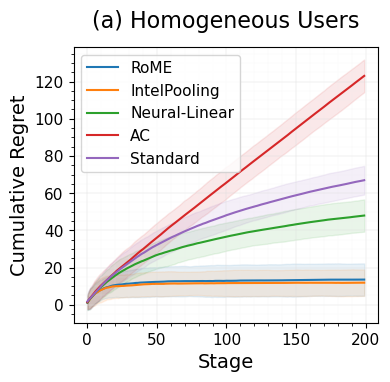

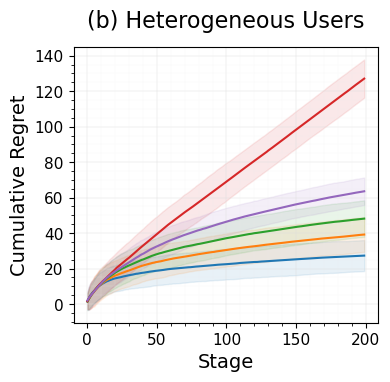

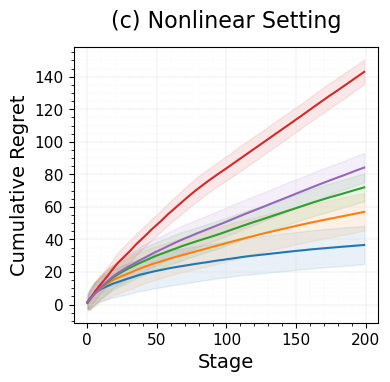

In [30]:
def plot_cumulative_regret(cumulative_regret_dict, setting_name, include_legend=False, loc="main", include_bands=True):
    fig, ax = plt.subplots(1, 1, figsize=(4,4))
    for i, method_name in enumerate(cumulative_regret_dict.keys()):
        color_i = f"C{i}"
        method_means = cumulative_regret_dict[method_name].mean(axis=1)
        method_range = np.arange(method_means.size)
        method_sds = cumulative_regret_dict[method_name].std(axis=1)
        method_lower = method_means - 1.96 * method_sds
        method_upper = method_means + 1.96 * method_sds
        if include_bands:
            ax.fill_between(method_range, method_lower, method_upper, color=color_i, alpha=0.1)
        ax.plot(method_range, method_means, label=method_name, color=color_i)
        
    ax.grid(which='major', color='#DDDDDD', linewidth=0.3)
    ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.3)
    ax.minorticks_on()
    ax.set_title(setting_name, pad=14, fontsize=16)
    ax.set_ylabel("Cumulative Regret", fontsize=14)
    ax.set_xlabel("Stage", fontsize=14)
    ax.tick_params(axis='both', labelsize=11)
    if include_legend:
        ax.legend(fontsize=11)

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    setting_name_for_file = setting_name.replace("(", "").replace(")", "").replace(" ", "-")
    fig.savefig(f"figures/cumulative-regret-{setting_name_for_file}-{loc}.png")
    fig.savefig(f"figures/cumulative-regret-{setting_name_for_file}-{loc}.pdf")
    # fig.suptitle("Comparison of Cumulative Regret by Method")
    plt.show()

main_paper_methods = ["RoME", "IntelPooling", "Neural-Linear", "AC", "Standard"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(a) Homogeneous Users", include_legend=True)

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in main_paper_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False)

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in main_paper_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False)

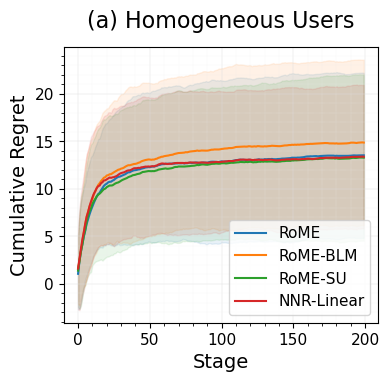

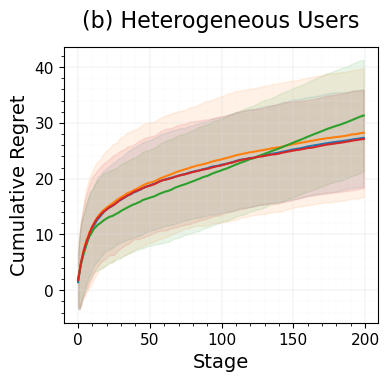

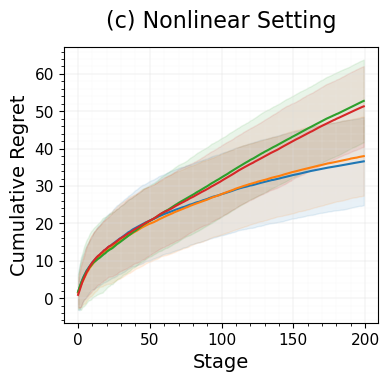

In [31]:
appendix_methods = ["RoME", "RoME-BLM", "RoME-SU", "NNR-Linear"]

plot_cumulative_regret(
    {m:cumulative_homogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(a) Homogeneous Users", include_legend=True, loc="app")

plot_cumulative_regret(
    {m:cumulative_heterogeneous_regret_dict[m] for m in appendix_methods},
    setting_name="(b) Heterogeneous Users", include_legend=False, loc="app")

plot_cumulative_regret(
    {m:cumulative_nonlinear_regret_dict[m] for m in appendix_methods},
    setting_name="(c) Nonlinear Setting", include_legend=False, loc="app")

## Comparison Tables

### Extra

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
final_homogeneous_regret_df = pd.read_csv("./checkpoints/final_homogeneous_regret.csv")
final_heterogeneous_regret_df = pd.read_csv("./checkpoints/final_heterogeneous_regret.csv")
final_nonlinear_regret_df = pd.read_csv("./checkpoints/final_nonlinear_regret.csv")

In [34]:
non_oracle_method_names_sorted = [
    'RoME',
    'RoME-BLM',
    'RoME-SU',
    'NNR-Linear',
    'IntelPooling',
    'Neural-Linear',
    'Standard',
    'AC',
]

In [35]:
def create_comparison_df(final_regret_df):
    comparison_outer_list = []
    win_percentages = []
    for method_row in non_oracle_method_names_sorted:
        comparison_inner_list = []
        win_percentage = 0.
        for method_column in non_oracle_method_names_sorted:
            diffs = final_regret_df[method_column] - final_regret_df[method_row]
            percent_row_better = np.mean(diffs > 0)
            avg_diff = np.mean(diffs)
            p_value = ttest_1samp(diffs, popmean=0).pvalue
            if method_row == method_column:
                cell_text = "-"
            else:
                win_percentage += percent_row_better / (len(non_oracle_method_names_sorted) - 1)
                cell_text = f"{percent_row_better:.0%}{'*' if p_value < 0.05 else ''}"
            comparison_inner_list.append(cell_text)
        comparison_outer_list.append(comparison_inner_list)
        win_percentages.append(f"{win_percentage:.0%}")
    comparison_df = pd.DataFrame(
        comparison_outer_list,
        index=[f"{i+1}. {n}" for i, n in enumerate(non_oracle_method_names_sorted)],
        columns=range(1, len(non_oracle_method_names_sorted)+1))
    comparison_df["\textbf{Avg}"] = win_percentages
    latex_table = comparison_df.to_latex(escape=False).replace("%", "\%")
    print(latex_table)
    return comparison_df

In [36]:
homogeneous_comparison_df = create_comparison_df(final_homogeneous_regret_df)
homogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 58\% & 48\% & 52\% & 30\%* & 100\%* & 100\%* & 100\%* & 70\% \\
2. RoME-BLM & 42\% & - & 40\%* & 36\%* & 22\%* & 100\%* & 100\%* & 100\%* & 63\% \\
3. RoME-SU & 52\% & 60\%* & - & 46\% & 34\%* & 100\%* & 100\%* & 100\%* & 70\% \\
4. NNR-Linear & 48\% & 64\%* & 54\% & - & 32\%* & 100\%* & 100\%* & 100\%* & 71\% \\
5. IntelPooling & 70\%* & 78\%* & 66\%* & 68\%* & - & 100\%* & 100\%* & 100\%* & 83\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 100\%* & 29\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 100\%* & 14\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,58%,48%,52%,30%*,100%*,100%*,100%*,70%
2. RoME-BLM,42%,-,40%*,36%*,22%*,100%*,100%*,100%*,63%
3. RoME-SU,52%,60%*,-,46%,34%*,100%*,100%*,100%*,70%
4. NNR-Linear,48%,64%*,54%,-,32%*,100%*,100%*,100%*,71%
5. IntelPooling,70%*,78%*,66%*,68%*,-,100%*,100%*,100%*,83%
6. Neural-Linear,0%*,0%*,0%*,0%*,0%*,-,100%*,100%*,29%
7. Standard,0%*,0%*,0%*,0%*,0%*,0%*,-,100%*,14%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [37]:
heterogeneous_comparison_df = create_comparison_df(final_heterogeneous_regret_df)
heterogeneous_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 46\% & 82\%* & 54\% & 100\%* & 100\%* & 100\%* & 100\%* & 83\% \\
2. RoME-BLM & 54\% & - & 70\%* & 48\% & 100\%* & 100\%* & 100\%* & 100\%* & 82\% \\
3. RoME-SU & 18\%* & 30\%* & - & 18\%* & 92\%* & 100\%* & 100\%* & 100\%* & 65\% \\
4. NNR-Linear & 46\% & 52\% & 82\%* & - & 100\%* & 100\%* & 100\%* & 100\%* & 83\% \\
5. IntelPooling & 0\%* & 0\%* & 8\%* & 0\%* & - & 90\%* & 100\%* & 100\%* & 43\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 10\%* & - & 98\%* & 100\%* & 30\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 15\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,46%,82%*,54%,100%*,100%*,100%*,100%*,83%
2. RoME-BLM,54%,-,70%*,48%,100%*,100%*,100%*,100%*,82%
3. RoME-SU,18%*,30%*,-,18%*,92%*,100%*,100%*,100%*,65%
4. NNR-Linear,46%,52%,82%*,-,100%*,100%*,100%*,100%*,83%
5. IntelPooling,0%*,0%*,8%*,0%*,-,90%*,100%*,100%*,43%
6. Neural-Linear,0%*,0%*,0%*,0%*,10%*,-,98%*,100%*,30%
7. Standard,0%*,0%*,0%*,0%*,0%*,2%*,-,100%*,15%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


### Nonlinear Setting

In [38]:
nonlinear_comparison_df = create_comparison_df(final_nonlinear_regret_df)
nonlinear_comparison_df

\begin{tabular}{llllllllll}
\toprule
 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 	extbf{Avg} \\
\midrule
1. RoME & - & 56\% & 100\%* & 96\%* & 98\%* & 100\%* & 100\%* & 100\%* & 93\% \\
2. RoME-BLM & 44\% & - & 94\%* & 98\%* & 100\%* & 100\%* & 100\%* & 100\%* & 91\% \\
3. RoME-SU & 0\%* & 6\%* & - & 38\% & 78\%* & 100\%* & 100\%* & 100\%* & 60\% \\
4. NNR-Linear & 4\%* & 2\%* & 62\% & - & 82\%* & 100\%* & 100\%* & 100\%* & 64\% \\
5. IntelPooling & 2\%* & 0\%* & 22\%* & 18\%* & - & 100\%* & 100\%* & 100\%* & 49\% \\
6. Neural-Linear & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 98\%* & 100\%* & 28\% \\
7. Standard & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 2\%* & - & 100\%* & 15\% \\
8. AC & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & 0\%* & - & 0\% \\
\bottomrule
\end{tabular}



,1,2,3,4,5,6,7,8,\textbf{Avg}
1. RoME,-,56%,100%*,96%*,98%*,100%*,100%*,100%*,93%
2. RoME-BLM,44%,-,94%*,98%*,100%*,100%*,100%*,100%*,91%
3. RoME-SU,0%*,6%*,-,38%,78%*,100%*,100%*,100%*,60%
4. NNR-Linear,4%*,2%*,62%,-,82%*,100%*,100%*,100%*,64%
5. IntelPooling,2%*,0%*,22%*,18%*,-,100%*,100%*,100%*,49%
6. Neural-Linear,0%*,0%*,0%*,0%*,0%*,-,98%*,100%*,28%
7. Standard,0%*,0%*,0%*,0%*,0%*,2%*,-,100%*,15%
8. AC,0%*,0%*,0%*,0%*,0%*,0%*,0%*,-,0%


In [39]:
final_nonlinear_regret_df

,IntelPooling,RoME-BLM,RoME,RoME-SU,AC,Standard,Neural-Linear,NNR-Linear
0,55.576990,34.770382,29.554636,48.907424,138.513413,84.164855,69.830174,50.465717
1,48.923903,30.248853,25.577689,51.993825,140.556270,69.450685,74.791743,50.160768
2,56.722796,35.832462,32.776534,56.305425,141.801915,75.972919,67.336755,46.095840
3,46.745882,28.305547,42.095342,51.033081,149.383349,86.952215,69.625137,42.921491
4,50.538686,33.620722,40.048566,44.922705,142.731606,79.730129,65.136302,46.876672
5,61.729105,31.742058,40.891344,49.474711,145.028294,83.884281,75.226993,46.822268
6,50.860804,34.930362,44.527089,49.067023,139.644067,86.083170,76.248491,54.588442
7,50.807392,46.737768,44.881609,46.032921,139.019617,81.792206,67.731245,41.255705
8,56.341955,30.306526,38.874366,43.234597,136.521394,86.701797,65.850040,42.156404
9,61.939008,44.121349,26.791374,53.277517,140.829186,87.312895,67.685142,54.800396


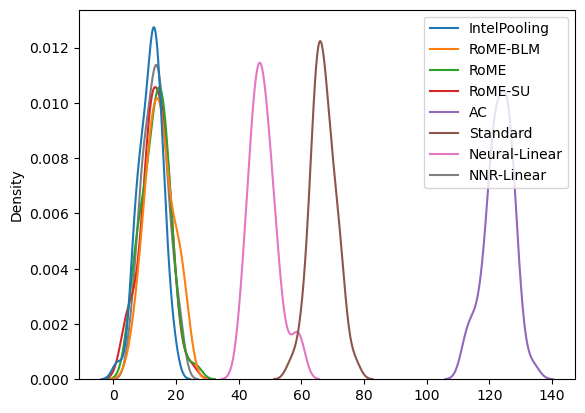

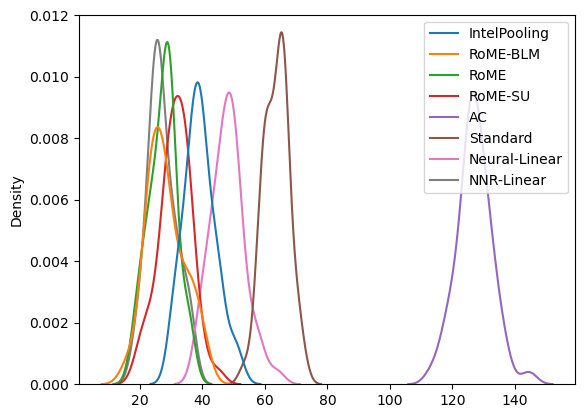

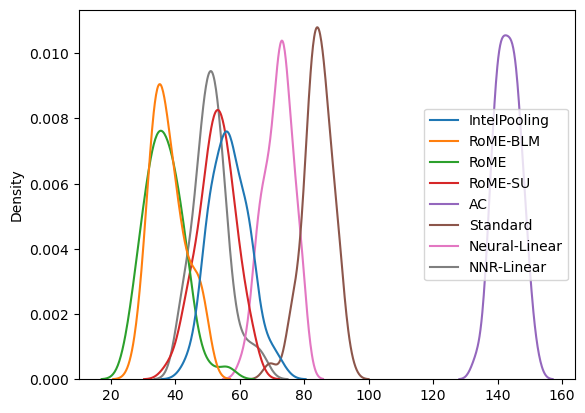

In [40]:
sns.kdeplot(data=final_homogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_heterogeneous_regret_df)
plt.show()

sns.kdeplot(data=final_nonlinear_regret_df)
plt.show()